# Installs

In [1]:
!pip install deeptrack
!pip install tensorflow
!/usr/local/cuda/bin/nvcc --version

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The system cannot find the path specified.


# Imports

In [2]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.layers import Layer, Dense, Attention, Concatenate, Dropout, LayerNormalization, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

C:\Users\axelg\AppData\Roaming\Python\Python311\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
C:\Users\axelg\AppData\Roaming\Python\Python311\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
C:\Users\axelg\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\axelg\AppData\Roaming\Python\Pyth

# Generate data

In [3]:
IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)

dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

Plots

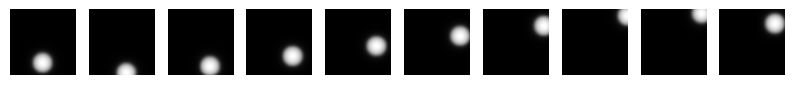

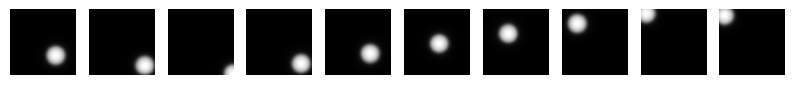

In [4]:
k=0
for sample_sequence in dataset:
    if k >= 2:
        break
    fig, axs = plt.subplots(1, sequence_length, figsize=(10, 3))
    for i in range(sequence_length):
        axs[i].imshow(sample_sequence[i][:, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.show()
    k += 1

# Variables

In [5]:
data_amount = 1000
seq_len = 9
latent_dim = 6
n_heads = 4
d_k= 32
d_v= d_k 
VERBOSE = False
#VERBOSE = True

# Choose dataset

In [6]:
frames = []
for i in range(data_amount):
    video = dataset.update().resolve() 
    for frame in video:
        frames.append(frame/np.max(frame))

if VERBOSE:
  print(frames[0].shape)    
  print(len(frames))

In [7]:
num_samples = len(frames)
split = 0.05
train_data = tf.stack(frames[int(split* num_samples):])
test_data = tf.stack(frames[:int(split * num_samples)])
if VERBOSE:
  print(len(train_data))

# Autoencoder

In [8]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim)
      ]) # Dimension: (None, latent_dim)

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
      tf.keras.layers.Dense(units=8 * 8 * 64, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.build((None, 64, 64, 1))
if VERBOSE:
  autoencoder.encoder.summary()
  autoencoder.decoder.summary()

# Train the autoencoder

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
autoencoder.fit(train_data, train_data,
                epochs=100,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[callback])
autoencoder.trainable = False

Epoch 1/100
297/297 [==============================] - 31s 98ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 2/100
297/297 [==============================] - 27s 92ms/step - loss: 0.0019 - val_loss: 9.3189e-04
Epoch 3/100
297/297 [==============================] - 27s 91ms/step - loss: 8.8079e-04 - val_loss: 5.3826e-04
Epoch 4/100
297/297 [==============================] - 27s 91ms/step - loss: 4.7292e-04 - val_loss: 4.2471e-04
Epoch 5/100
297/297 [==============================] - 27s 91ms/step - loss: 3.5052e-04 - val_loss: 2.7480e-04
Epoch 6/100
297/297 [==============================] - 29s 97ms/step - loss: 2.5324e-04 - val_loss: 2.5745e-04
Epoch 7/100
297/297 [==============================] - 27s 90ms/step - loss: 2.4137e-04 - val_loss: 1.8900e-04
Epoch 8/100
297/297 [==============================] - 27s 91ms/step - loss: 1.7550e-04 - val_loss: 1.5673e-04
Epoch 9/100
297/297 [==============================] - 27s 92ms/step - loss: 2.4673e-04 - val_loss: 1.6382e-04
Epoch 10/100


# Plot

In [10]:
def plot_comparasion(decoded, train_data, num_pics=10):
  plt.figure(figsize=(20, 4))
  for i in range(num_pics):
    # Original
    ax = plt.subplot(2, num_pics, i + 1)
    plt.imshow(train_data[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed
    ax = plt.subplot(2, num_pics, i + 1 + num_pics)
    plt.imshow(decoded[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def plot_detailed(decoded, train_data):
  plt.figure(figsize=(12, 6))
  # Original
  ax1 = plt.subplot(1, 2, 1)
  plt.imshow(train_data[0])
  ax1.axis('off')
  # Reconstructed
  ax2 = plt.subplot(1, 2, 2)
  plt.imshow(decoded[0])
  ax2.axis('off')
  plt.show()

def plot_loss_history(history):
  # Train and validation loss
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot loss history
  plt.plot(train_loss, label='train')
  plt.plot(val_loss, label='val')
  plt.title('Training and validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

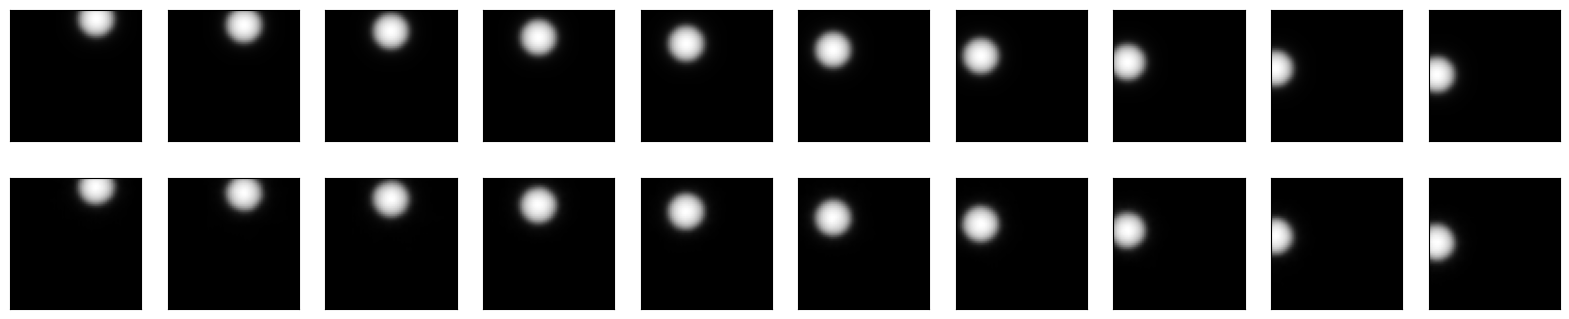

In [11]:
encoded = autoencoder.encoder(train_data).numpy()
decoded = autoencoder.decoder(encoded).numpy()
plot_comparasion(decoded, train_data)
if VERBOSE:
  plot_detailed(decoded, train_data)

# Time2vec and SingleAttention


In [12]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    self.bias_linear = self.add_weight(name='bias_linear', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    self.weights_periodic = self.add_weight(name='weight_periodic', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    self.bias_periodic = self.add_weight(name='bias_periodic', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    
  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1)
    
    return tf.concat([time_linear, time_periodic], axis=-1)

class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
  
  def build(self, input_shape):
    self.query = Dense(self.d_k, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = Dense(self.d_k, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = Dense(self.d_v, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
  
  def call(self, input): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(input)
    k = self.key(input)
    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    v = self.value(input)
    attn_out = tf.matmul(attn_weights, v)

    return attn_out

# Multihead attention

In [13]:
class MultiHeadAttention(Layer):
    def __init__(self, nr_heads, d_k, d_v, latent_dim, **kwargs):
      super(MultiHeadAttention, self).__init__()
      self.d_k = d_k
      self.d_v = d_v
      self.nr_heads = nr_heads
      self.attn_heads = list()
      self.latent_dim = latent_dim
      self.depth_per_head = int((latent_dim+2)/nr_heads)

    def build(self, input_shape): # Batch seq_len latdim+2
      for i in range(self.nr_heads):
        self.attn_heads.append(SingleAttention(self.d_k,self.d_v))
      self.linear1 = Dense(self.latent_dim+2, input_shape=input_shape)

    def call(self, x):
      outputs = [self.attn_heads[i](x) for i in range(self.nr_heads)]
      concated = Concatenate(axis=-1)(outputs)
      multi_attention = self.linear1(concated) # Batch_size, seq_len, latent_dim+2      
      return multi_attention 

# Transformer

In [14]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v,latent_dim, n_heads, **kwargs):
      super(TransformerEncoder, self).__init__()
      self.d_k = d_k
      self.d_v = d_v
      self.n_heads=n_heads
      self.latent_dim=latent_dim

    def build(self,input_shape):
      self.multiHeadAtt = MultiHeadAttention(self.n_heads, self.d_k, self.d_v, self.latent_dim)
      self.linear1 = Dense(self.latent_dim+2)
      self.norm = LayerNormalization()
      self.dropout = Dropout(.3)

    def call(self, x): # Batch_size, seq_len, latent_dim+2
      tmp_x = self.multiHeadAtt(x)
      tmp_x = self.dropout(tmp_x)
      tmp_x = self.norm(x + tmp_x)
      tmp_x = self.linear1(tmp_x)
      tmp_x = self.norm(x + tmp_x)
      return tmp_x

# Global model

In [15]:
class GlobalModel(Model):
  """Takes input from encoder and outputs an encoded version of the next frame"""

  def __init__(self, seq_len, latent_dim, n_heads, d_k, d_v):
    super(GlobalModel, self).__init__()
    self.latent_dim = latent_dim
    self.seq_len = seq_len
    self.dropout = Dropout(.3)
    self.time_embedding = Time2Vector(seq_len)
    
    self.transformer1 = TransformerEncoder(d_k, d_v,latent_dim, n_heads)
    self.transformer2 = TransformerEncoder(d_k, d_v,latent_dim, n_heads)
    self.transformer3 = TransformerEncoder(d_k, d_v,latent_dim, n_heads)
    
    self.dense1 = Dense(64, activation='relu')
    self.dense2 = Dense(64, activation='relu')
    self.dense3 = Dense(64, activation='relu')
    self.dense_final = Dense(latent_dim)
    

  def call(self, inputs): # Batch_size, seq_len, latent_dim
    x = self.time_embedding(inputs)
    x = Concatenate(axis=-1)([inputs, x]) # Batch_size, seq_len, latent_dim+2
    x = self.transformer1(x)
    x = self.transformer2(x)
    x = self.transformer3(x)

    x = Flatten()(x)
    x = self.dense1(x)
    x = self.dropout(x)
    x = self.dense2(x)
    x = self.dropout(x)
    x = self.dense3(x)
    x = self.dense_final(x) # Batch_size, latent_dim
    return x

# Train

In [16]:
# Prepare data
encoded_train = autoencoder.encoder(train_data)
encoded_test  = autoencoder.encoder(test_data)

train_reshaped = tf.reshape(encoded_train,(int(len(train_data)/10), 10,latent_dim))
train_x = train_reshaped[:,:9,:]
train_y = train_reshaped[:,9,:]

test_reshaped = tf.reshape(encoded_test,(int(len(test_data)/10),10,latent_dim))
test_x = test_reshaped[:,:9,:]
test_y = test_reshaped[:,9,:]

Epoch 1/100
30/30 [==============================] - 18s 110ms/step - loss: 2.7980 - val_loss: 2.1292
Epoch 2/100
30/30 [==============================] - 1s 41ms/step - loss: 2.4430 - val_loss: 1.8780
Epoch 3/100
30/30 [==============================] - 1s 43ms/step - loss: 2.0700 - val_loss: 1.5808
Epoch 4/100
30/30 [==============================] - 1s 42ms/step - loss: 1.8246 - val_loss: 1.2647
Epoch 5/100
30/30 [==============================] - 1s 42ms/step - loss: 1.6892 - val_loss: 1.2350
Epoch 6/100
30/30 [==============================] - 1s 41ms/step - loss: 1.5328 - val_loss: 1.1557
Epoch 7/100
30/30 [==============================] - 1s 43ms/step - loss: 1.4169 - val_loss: 1.1021
Epoch 8/100
30/30 [==============================] - 1s 43ms/step - loss: 1.3525 - val_loss: 0.9681
Epoch 9/100
30/30 [==============================] - 1s 42ms/step - loss: 1.2609 - val_loss: 0.9644
Epoch 10/100
30/30 [==============================] - 1s 41ms/step - loss: 1.1842 - val_loss: 0.87

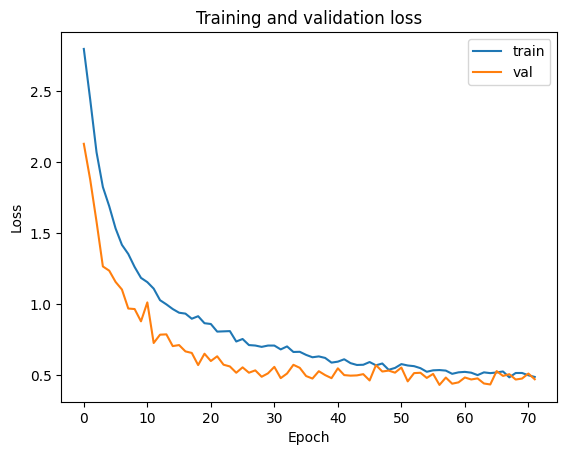

In [17]:
model = GlobalModel(seq_len, latent_dim, n_heads, d_k, d_v)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
history = model.fit(train_x, train_y, epochs=100, verbose=1, validation_data=(test_x, test_y), callbacks=[callback])
plot_loss_history(history)

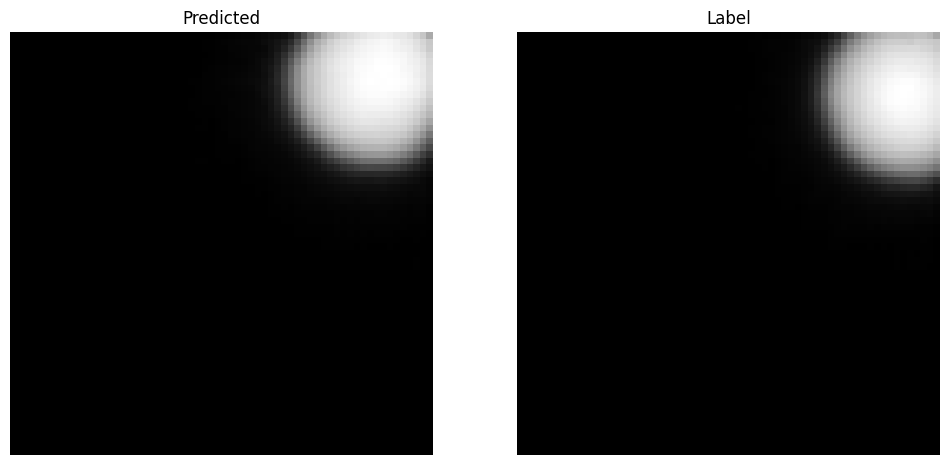

In [18]:
plt.figure(figsize=(12, 6))

# Original
ax1 = plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.imshow(autoencoder.decoder(model(test_x))[0])
ax1.axis('off')

# Reconstructed
ax2 = plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(autoencoder.decoder(test_y)[0])
ax2.axis('off')

plt.show()

# Predict the future long term

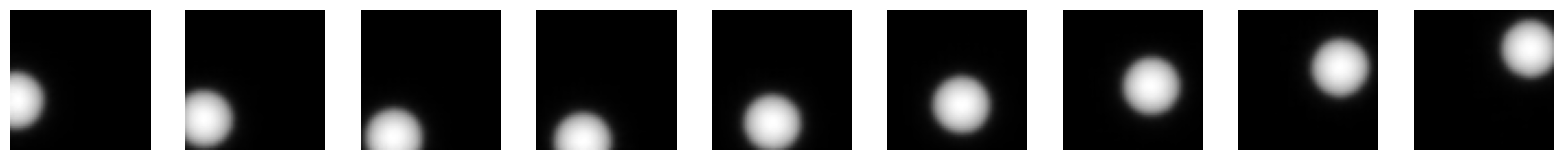

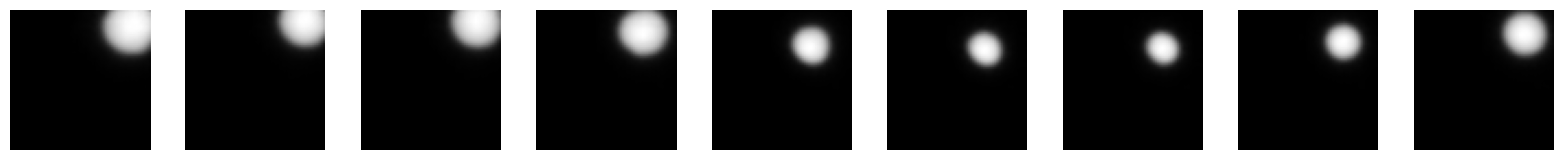

In [72]:
nr_predictions = 9

sequence = test_x[0] # take first sequence from test data
sequence = np.expand_dims(sequence, axis=0) 

# Plot the normal sequence
decoded = autoencoder.decoder(test_x[0])
plt.figure(figsize=(20, 4))
for i in range(nr_predictions):
    ax = plt.subplot(2, nr_predictions, i+1)
    plt.imshow(decoded[i])
    ax.axis('off')
plt.show()

#plot the predicted sequence
for i in range(nr_predictions):
    sequence = Concatenate(axis=1)([sequence[:,1:,:],np.expand_dims(model(sequence), axis=0)]) # next prediction 
images = autoencoder.decoder(tf.reshape(sequence, (seq_len, latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(nr_predictions):
    ax = plt.subplot(2, nr_predictions, i+1)
    plt.imshow(images[i])
    ax.axis('off')
plt.show()

# LSTM

In [39]:
from keras.layers import LSTM
nodes = 512
LSTM_model = Sequential([
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(seq_len, latent_dim)),
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=False),
    Dropout(0.4),
    Dense(latent_dim)
])

Epoch 1/100
30/30 [==============================] - 21s 498ms/step - loss: 2.8967 - val_loss: 2.5342
Epoch 2/100
30/30 [==============================] - 15s 492ms/step - loss: 2.7588 - val_loss: 2.2590
Epoch 3/100
30/30 [==============================] - 15s 494ms/step - loss: 2.4296 - val_loss: 2.1246
Epoch 4/100
30/30 [==============================] - 16s 520ms/step - loss: 1.9737 - val_loss: 1.7658
Epoch 5/100
30/30 [==============================] - 17s 584ms/step - loss: 1.6861 - val_loss: 1.5562
Epoch 6/100
30/30 [==============================] - 17s 565ms/step - loss: 1.3595 - val_loss: 1.3230
Epoch 7/100
30/30 [==============================] - 17s 568ms/step - loss: 1.1159 - val_loss: 0.9898
Epoch 8/100
30/30 [==============================] - 15s 514ms/step - loss: 0.9010 - val_loss: 0.9065
Epoch 9/100
30/30 [==============================] - 15s 505ms/step - loss: 0.6925 - val_loss: 0.6565
Epoch 10/100
30/30 [==============================] - 16s 529ms/step - loss: 0.578

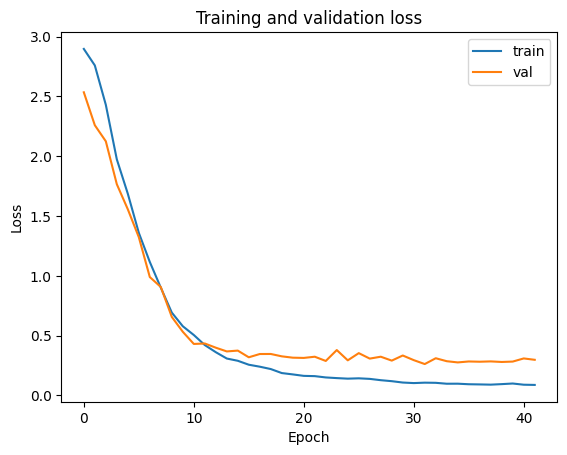

In [42]:
LSTM_model.compile(loss='mse', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
history = LSTM_model.fit(train_x, train_y, epochs=100, verbose=1, validation_data=(test_x, test_y), callbacks=[callback])
plot_loss_history(history)

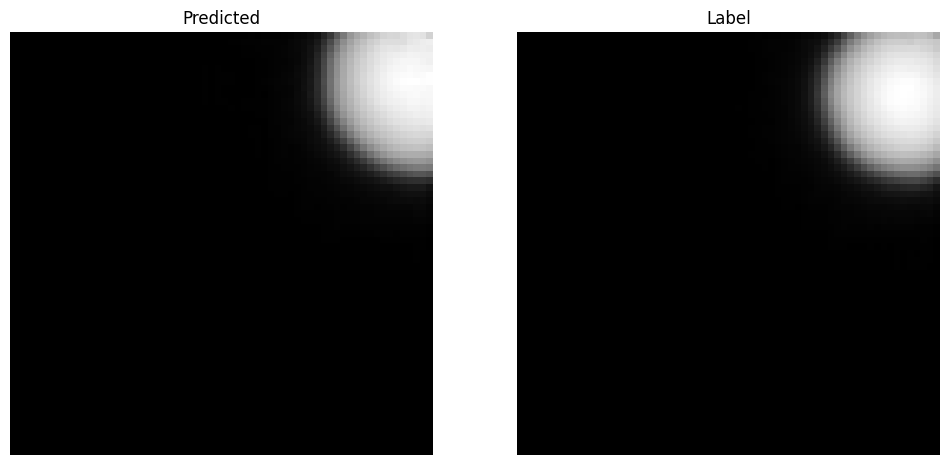

In [44]:
pred = LSTM_model(test_x)
pred_frame = autoencoder.decoder(pred)[0]
correct_frame = autoencoder.decoder(test_y)[0]

plt.figure(figsize=(12, 6))
# Original
ax1 = plt.subplot(1, 2, 1)
plt.imshow(pred_frame)
plt.title("Predicted")
ax1.axis('off')
# Reconstructed
ax2 = plt.subplot(1, 2, 2)
plt.imshow(correct_frame)

ax2.axis('off')
plt.show()

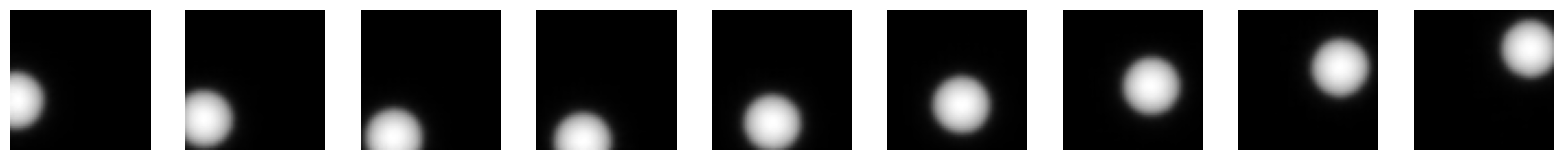

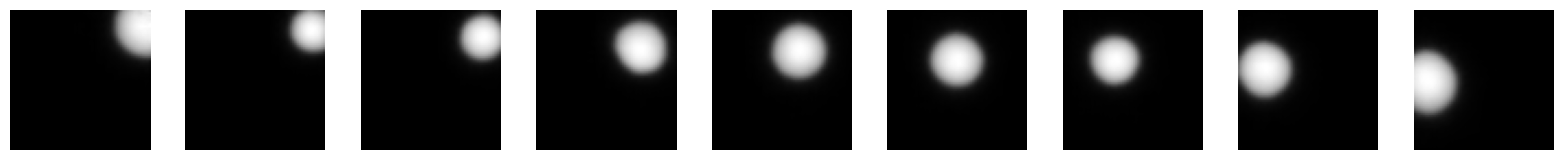

In [71]:
nr_predictions = 9

sequence = test_x[0] # take first sequence from test data
sequence = np.expand_dims(sequence, axis=0) 

# Plot the normal sequence
decoded = autoencoder.decoder(test_x[0])
plt.figure(figsize=(20, 4))
for i in range(nr_predictions):
    ax = plt.subplot(2, nr_predictions, i+1)
    plt.imshow(decoded[i])
    ax.axis('off')
plt.show()

#plot the predicted sequence
for i in range(nr_predictions):
    sequence = Concatenate(axis=1)([sequence[:,1:,:],np.expand_dims(LSTM_model(sequence), axis=0)]) # next prediction 
images = autoencoder.decoder(tf.reshape(sequence, (seq_len, latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(nr_predictions):
    ax = plt.subplot(2, nr_predictions, i+1)
    plt.imshow(images[i])
    ax.axis('off')
plt.show()


In [ ]:
# Define the model architecture
nodes = 512
activation = 'tanh'
recurrent_activation = 'sigmoid'
dropout_rate = 0.4

LSTM = tf.keras.Sequential([
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, input_shape=(seq_len, latent_dim)),
    Dropout(dropout_rate),
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False),
    Dropout(dropout_rate),
    Dense(latent_dim)
])

# Define the optimizer and loss function
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = 'mae'

# Compile the model
LSTM.compile(optimizer=optimizer, loss=loss)

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True)
def scheduler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.05)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = LSTM.fit(train_x, train_y, epochs=100, verbose=1, validation_data=(test_x, test_y), callbacks=[early_stopping, lr_scheduler])
plot_loss_history(history)